In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.examples. tutorials.mnist import input_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils as np_utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [2]:
dic = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
class my_callback(Callback):
    def __init__(self, data):
        self.x = data[0]
        self.y = data[1]
        self.acc = []
    def on_epoch_end(self, epoch, logs=None):
        predict = self.model.predict(self.x)
        acc = tf.metrics.categorical_accuracy(self.y,predict).numpy().mean()
        self.acc.append(acc)
    def get_history(self):
        return self.acc

In [4]:
def draw_learning_curve(train_acc, val_acc, test_acc):
    t = range(len(train_acc))
    plt.plot(t, train_acc, label='train')
    plt.plot(t, val_acc, label='val')
    plt.plot(t, test_acc, label='test')
    plt.legend()
    plt.show()

In [5]:
def draw_loss(train_loss):
    t = range(len(train_loss))
    plt.plot(t, train_loss, label='Cross entropy')
    plt.legend()
    plt.show()

In [6]:
def draw_distributions(layers):
    for i, layer in enumerate(layers):
        name = layer.name
        if not layer.get_weights() :
            continue
        weight, bias = layer.get_weights()
        plt.figure()
        plt.subplot(121)
        plt.hist(weight.flatten(), 100)
        plt.xlabel(name + '_weight')
        plt.ylabel('number')
        plt.subplot(122)
        plt.hist(bias.flatten(), 100)
        plt.xlabel(name + '_bias')
        plt.ylabel('number')
    plt.show() 

In [7]:
def false_predict(x_test, Y_test, predict):
    count = 0
    plt.figure()
    for index, my_pred in enumerate(predict):
        pred_label = np.argmax(my_pred)
        if pred_label != Y_test[index]:
            plt.imshow(x_test[index], cmap='gray')
            img1 = x_test[index][np.newaxis]
            plt.title('label: %s, pred: %s' % (dic[Y_test[index][0]], dic[pred_label]))
            break
    cor_index = np.where(Y_test == pred_label)[0][0]
    plt.figure()
    plt.imshow(x_test[cor_index], cmap='gray')
    img2 = x_test[cor_index][np.newaxis]
    plt.title('label: %s, pred: %s' % (dic[Y_test[cor_index][0]], dic[np.argmax(predict[cor_index])]))
    return (img1, img2)

In [8]:
def feature_map(model, img):
    img = preprocess(img).reshape(-1, 32, 32, 1)/255
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input,outputs=layer_outputs)
    activations = activation_model.predict(img)
    for index, layer in enumerate(model.layers):
        if layer.name[:3] == 'con':
            plt.figure()
            count = 1
            for i in range(7):
                #plt.figure()
                plt.subplot(100*count + 10*7 + i+1)
                feature = activations[index][0,:,:,i]
                plt.imshow(feature, cmap='gray')
            count += 1

In [20]:
def without_l2(input_size, kernel_size, stride):
    model = Sequential()  
    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=stride, input_shape=(32,32,1),activation='relu',padding='same'))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=stride, activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=stride, activation='relu',padding='same'))
    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=stride, activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=stride, activation='relu',padding='same'))
    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=stride, activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()
    return model

In [21]:
def with_l2(input_size, kernel_size, stride):
    l2_rate = 0.000001
    model = Sequential()  
    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=stride, input_shape=(32,32,1),activation='relu',padding='same', kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, strides=stride, activation='relu',padding='same', kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=stride, activation='relu',padding='same', kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=stride, activation='relu',padding='same', kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=stride, activation='relu',padding='same', kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=stride, activation='relu',padding='same',kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()
    return model

In [22]:
def my_train(model, epochs):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    test_loss =[]
    test_acc = []
    callback = my_callback([x_test, y_test])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, shuffle=True, validation_data=(x_val, y_val), callbacks=[callback])
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    test_acc = callback.get_history()
    return (train_loss, train_acc, val_loss, val_acc, test_acc)

In [23]:
def preprocess(imgs):
    imgs = np.dot(imgs[...,:3], [0.2989, 0.5870, 0.1140])
    return imgs

In [24]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [25]:
X_train_gray = preprocess(X_train)
X_test_gray = preprocess(X_test)

In [26]:
x_train = X_train_gray.reshape(-1, 32, 32, 1)/255
x_test = X_test_gray.reshape(-1, 32, 32, 1)/255
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
Y_train = Y_train[indices]
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)

In [27]:
x_val = x_train[:5000]
x_train = x_train[5000:]
y_val = y_train[:5000]
y_train = y_train[5000:]

In [18]:
input_size = (32,32,1)
kernel_size = (3,3)
stride = (1,1)
model = without_l2(input_size, kernel_size, stride)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0

In [19]:
train_loss, train_acc, val_loss, val_acc, test_acc = my_train(model, 50)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 20s 449us/sample - loss: 1.7268 - accuracy: 0.3607 - val_loss: 1.3939 - val_accuracy: 0.5114
Epoch 2/50
45000/45000 [==============================] - 18s 394us/sample - loss: 1.1323 - accuracy: 0.6012 - val_loss: 1.0001 - val_accuracy: 0.6568
Epoch 3/50
45000/45000 [==============================] - 18s 394us/sample - loss: 0.8784 - accuracy: 0.6948 - val_loss: 0.8377 - val_accuracy: 0.7210
Epoch 4/50
45000/45000 [==============================] - 18s 396us/sample - loss: 0.7434 - accuracy: 0.7440 - val_loss: 0.7669 - val_accuracy: 0.7322
Epoch 5/50
45000/45000 [==============================] - 18s 391us/sample - loss: 0.6388 - accuracy: 0.7768 - val_loss: 0.7211 - val_accuracy: 0.7572
Epoch 6/50
45000/45000 [==============================] - 18s 393us/sample - loss: 0.5639 - accuracy: 0.8054 - val_loss: 0.6932 - val_accuracy: 0.7572
Epoch 7/50
45000/45000 [=====================

In [30]:
print(model.evaluate(x_test, y_test))
draw_learning_curve(train_acc, val_acc, test_acc)
draw_loss(train_loss)
draw_distributions(model.layers)
img1, img2 = false_predict(X_test, Y_test, model.predict(x_test))
feature_map(model, img1)
feature_map(model, img2)

10000/10000 [==============================] - 2s 191us/sample - loss: 1.7196 - accuracy: 0.3785
[1.719557993888855, 0.3785]


NameError: name 'train_acc' is not defined

In [31]:
input_size = (32,32,1)
kernel_size = (3,3)
stride = (1,1)
model = with_l2(input_size, kernel_size, stride)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)      

In [32]:
train_loss, train_acc, val_loss, val_acc, test_acc = my_train(model, 50)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 24s 524us/sample - loss: 1.6533 - accuracy: 0.3963 - val_loss: 1.4687 - val_accuracy: 0.4954
Epoch 2/50
45000/45000 [==============================] - 20s 453us/sample - loss: 1.0905 - accuracy: 0.6188 - val_loss: 1.1326 - val_accuracy: 0.6152
Epoch 3/50
45000/45000 [==============================] - 20s 448us/sample - loss: 0.8430 - accuracy: 0.7072 - val_loss: 0.9584 - val_accuracy: 0.6722
Epoch 4/50
45000/45000 [==============================] - 20s 452us/sample - loss: 0.7055 - accuracy: 0.7555 - val_loss: 0.7745 - val_accuracy: 0.7296
Epoch 5/50
45000/45000 [==============================] - 21s 457us/sample - loss: 0.6004 - accuracy: 0.7922 - val_loss: 0.7356 - val_accuracy: 0.7430
Epoch 6/50
45000/45000 [==============================] - 21s 457us/sample - loss: 0.5130 - accuracy: 0.8221 - val_loss: 0.7056 - val_accuracy: 0.7512
Epoch 7/50
45000/45000 [=====================

10000/10000 [==============================] - 2s 198us/sample - loss: 1.1804 - accuracy: 0.7705
[1.180353290081024, 0.7705]


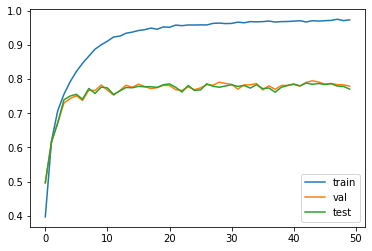

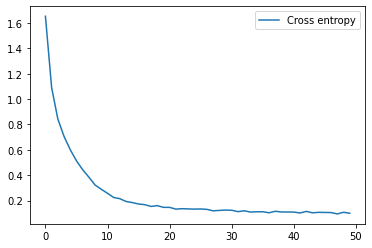

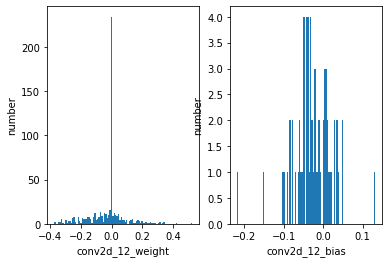

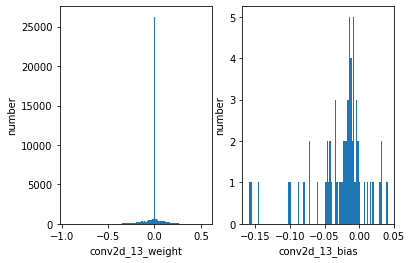

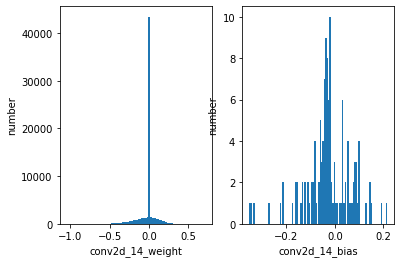

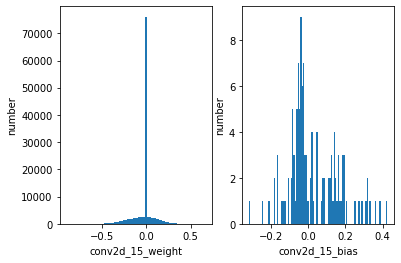

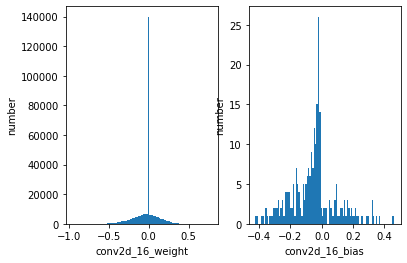

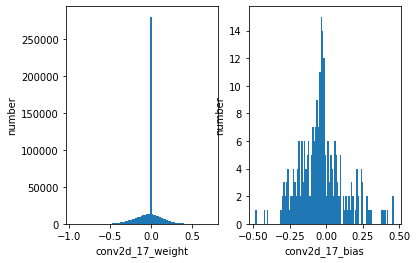

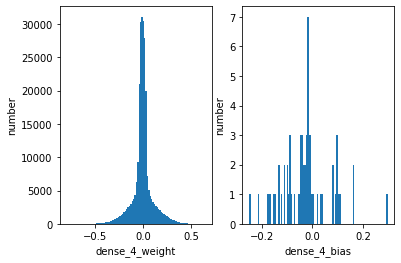

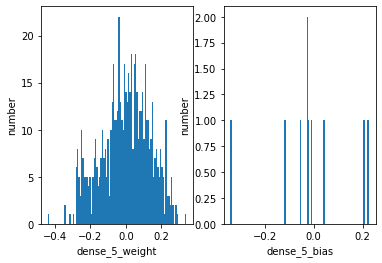

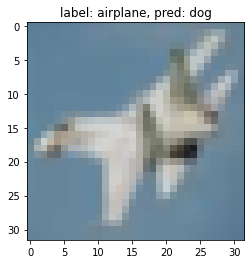

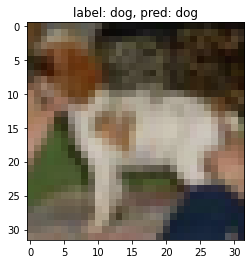

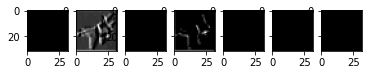

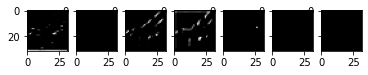

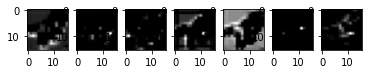

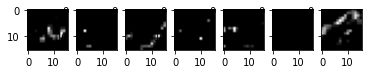

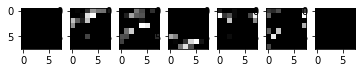

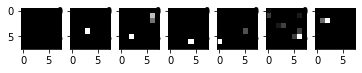

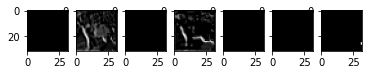

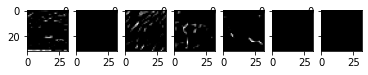

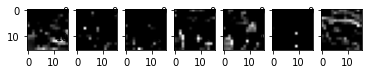

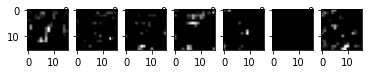

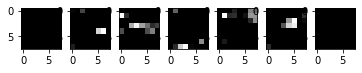

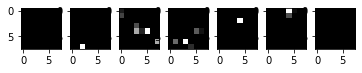

In [35]:
print(model.evaluate(x_test, y_test))
draw_learning_curve(train_acc, val_acc, test_acc)
draw_loss(train_loss)
draw_distributions(model.layers)
img1, img2 = false_predict(X_test, Y_test, model.predict(x_test))
feature_map(model, img1)
feature_map(model, img2)